<H1><B>NYC 2013 Flight data analysis</B></H1><hr>

In [4]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
from matplotlib import pyplot as plt

from ggplot import *

import seaborn as sns
import pandas_profiling

#to hide warnings
import warnings as warn
warn.filterwarnings = 'ignore'

from collections import Counter

In [11]:
## Loading Flight Data 
airport_data_df=pd.read_csv(r'flight_data.csv')

##Loading Airport Name Data
airport_name_df=pd.read_csv(r'airports.csv')

##Loading Weather data
weather_data_df=pd.read_csv(r'weather.csv')

##Loading Plane data
plane_df=pd.read_csv(r'planes.csv')

report = pandas_profiling.ProfileReport(airport_data_df)
#covert profile report as html file
report.to_file("airport_data.html")


In [12]:
def dep_delay (x):
    if x == 0 or x < 0:
        return 0
    else:
        return 1

<img src='dep_delay.png'>

In [13]:
## As dep_delay is not available for just 2.5% of data as seen above
## We will not consider such data for our analysis
## And as Arrival delay is highly correlated to Departure Delay we will take dep delay for analysis
airport_data_df.dropna(subset =['dep_delay'], inplace=True)


In [14]:
#Getting details of planes via tailnum
airport_data_df = pd.merge(plane_df,airport_data_df,left_on='tailnum',right_on='tailnum',how='right')
airport_data_df.head()

,tailnum,year_manu,type,manufacturer,model,engines,seats,speed,engine,year,...,arr_delay,carrier,flight,origin,dest,air_time,distance,hour,minute,time_hour
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,2.0,EV,4560,EWR,PIT,60.0,319,6,30,10-01-2013 06:00
1,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,40.0,EV,4269,EWR,CHS,99.0,628,10,32,10-01-2013 10:00
2,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,47.0,EV,4667,EWR,MSP,175.0,1008,15,40,10-01-2013 15:00
3,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,-12.0,EV,4334,EWR,CMH,81.0,463,6,34,11-01-2013 06:00
4,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,-8.0,EV,4298,EWR,MCI,171.0,1092,11,20,11-01-2013 11:00


In [15]:
# Checking for Delay in departures
airport_data_df.loc[airport_data_df['dep_delay'] == 0]
airport_data_df['dep_delay_ind'] = airport_data_df.dep_delay.apply(dep_delay)
airport_data_df.head()

,tailnum,year_manu,type,manufacturer,model,engines,seats,speed,engine,year,...,carrier,flight,origin,dest,air_time,distance,hour,minute,time_hour,dep_delay_ind
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,EV,4560,EWR,PIT,60.0,319,6,30,10-01-2013 06:00,0
1,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,EV,4269,EWR,CHS,99.0,628,10,32,10-01-2013 10:00,1
2,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,EV,4667,EWR,MSP,175.0,1008,15,40,10-01-2013 15:00,1
3,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,EV,4334,EWR,CMH,81.0,463,6,34,11-01-2013 06:00,0
4,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,NaN,Turbo-fan,2013,...,EV,4298,EWR,MCI,171.0,1092,11,20,11-01-2013 11:00,0


### <HR><CENTER>Analysing the Data</CENTER><HR>

  origin                                  Name      City        Country  \
0    EWR  Newark Liberty International Airport    Newark  United States   
1    JFK  John F Kennedy International Airport  New York  United States   
2    LGA                    La Guardia Airport  New York  United States   

   total count  delay_count  Delay_count%   On_time%  
0       117596        52711     44.823804  55.176196  
1       109416        42031     38.413943  61.586057  
2       101509        33690     33.189175  66.810825  


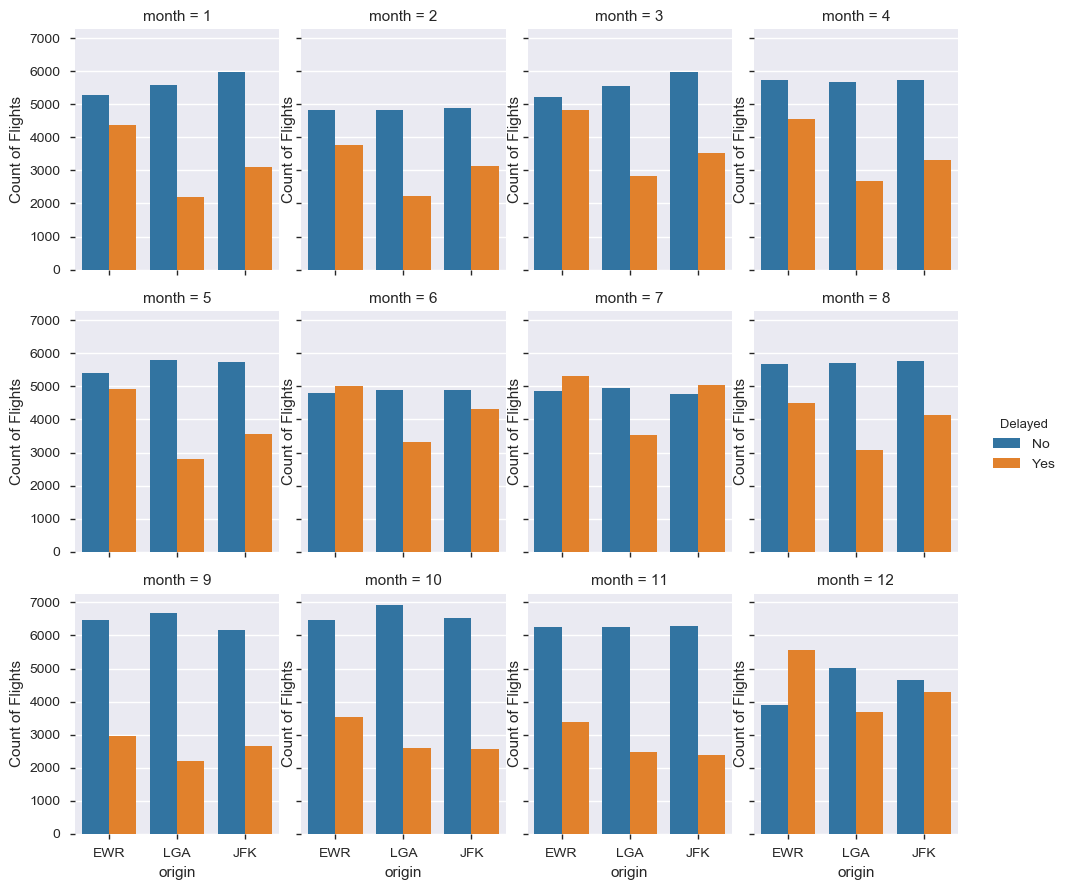

In [16]:
#======================= Getting the count of flights departed from different airports in 2013 ==============================
orig = airport_data_df.groupby('origin')
## count of flights departed in 2013
orig_count= orig['dep_delay'].agg('count').reset_index(name='total count')
## Count of flights with delayed departure in 2013
orig_delay_count= orig['dep_delay'].apply(lambda x: (x>0).sum()).reset_index(name='delay_count')

orig_count['delay_count']= orig_delay_count['delay_count']
Flight_count = pd.merge(orig_count,airport_name_df[['IATA','Name','City','Country']],left_on='origin',right_on='IATA',how='left')
Flight_count['Delay_count%'] = (Flight_count['delay_count']/Flight_count['total count'])*100
Flight_count['On_time%'] = ((Flight_count['total count']-Flight_count['delay_count'])/Flight_count['total count'])*100
print(Flight_count[['origin','Name','City','Country','total count','delay_count','Delay_count%','On_time%']])

############################### Representing Data into visual Format for better understanding ###############################
mx = sns.catplot(x="origin", hue="dep_delay_ind", data=airport_data_df, kind="count",col="month"
                 ,col_wrap=4, height=3, aspect=.8, legend_out=True)
mx.set(ylabel='Count of Flights')
# Change title of Legend
new_title = 'Delayed'
mx._legend.set_title(new_title)
# Replace labels of Legend
new_labels = ['No', 'Yes']
for t, l in zip(mx._legend.texts, new_labels): t.set_text(l)

#============================================================================================================================

#### Airport with maximum flight traffic and delayed departures.
> According to the above result we see that Most Flights departed from Newark Liberty International Airport and having maximum number of delayed departures specially in the month of december 2013.

In [17]:
#===================== Getting day of 2013 having the maximum average delay (depature & arrival) ============================
delay_day_stg = airport_data_df[['day','month','origin','dep_delay','arr_delay']].loc[airport_data_df['dep_delay']>0]
delay_day= delay_day_stg.groupby(['month','day'],as_index=False)['dep_delay'].agg({"Average delay in minutes": "mean"})
print(delay_day.loc[delay_day['Average delay in minutes'].idxmax()] )
print("------------------------------------------------------------------")
print(delay_day_stg.loc[(delay_day_stg['day']== 8) & (delay_day_stg['month'] == 3) ].groupby(['origin','month','day'],as_index=False)['dep_delay'].agg({"Average delay in minutes": "mean"}))

month                         3.000000
day                           8.000000
Average delay in minutes    102.903522
Name: 66, dtype: float64
------------------------------------------------------------------
  origin  month  day  Average delay in minutes
0    EWR      3    8                120.525346
1    JFK      3    8                 70.285714
2    LGA      3    8                122.797980


#### Worst Hit day of 2013
> As seen above, the worst day to fly in 2013 (across all 3 airports ) would’ve been the March 8 ,2013 with an average delay of 102 minutes i.e. 1hr 42 minutes. 
***
> Further, we observe that La Guardia Airport was worst hit on March 8 ,2013 with an average delay of 122 minutes.

In [18]:
#======================= Getting the count of flights departed from different airports in 2013 (on time) ====================
orig = airport_data_df.groupby('origin')
## count of flights departed in 2013
orig_on_time= orig['dep_delay'].agg('count').reset_index(name='total count')
## Count of flights with on time or early departure in 2013
orig_on_time_count = orig['dep_delay'].apply(lambda x: (x<=0).sum()).reset_index(name='on_time_count')
orig_on_time['on_time_count'] = orig_on_time_count['on_time_count']

Flight_on_time_count = pd.merge(orig_on_time,airport_name_df[['IATA','Name','City','Country']],left_on='origin',right_on='IATA',how='left')
Flight_on_time_count.sort_values('on_time_count', ascending=False)

,origin,total count,on_time_count,IATA,Name,City,Country
2,LGA,101509,67819,LGA,La Guardia Airport,New York,United States
1,JFK,109416,67385,JFK,John F Kennedy International Airport,New York,United States
0,EWR,117596,64885,EWR,Newark Liberty International Airport,Newark,United States


#### Best Airport in terms of Departures.
> According to the above result we see that best airport in terms of on time departures is La Guardia Airport of New York.

In [19]:
#=============================== Getting the count of flights going to particular location =================================
dest = airport_data_df.groupby('dest')
## count of flights headed to same destination in 2013
dest_cnt= dest['dest'].agg('count').reset_index(name='total count')
dest_cnt_final = pd.merge(dest_cnt,airport_name_df[['IATA','Name','City','Country']], left_on ='dest', right_on ='IATA', how='left')
dest_cnt_final.sort_values('total count', ascending=False).head()

,dest,total count,IATA,Name,City,Country
4,ATL,16898,ATL,Hartsfield Jackson Atlanta International Airport,Atlanta,United States
68,ORD,16642,ORD,Chicago O'Hare International Airport,Chicago,United States
49,LAX,16076,LAX,Los Angeles International Airport,Los Angeles,United States
11,BOS,15049,BOS,General Edward Lawrence Logan International Ai...,Boston,United States
53,MCO,13982,MCO,Orlando International Airport,Orlando,United States


In [20]:
#=============================== Getting the origination of flights going to Atlanta location ==============================
dest_ATL = airport_data_df[airport_data_df['dest'] == 'ATL'].groupby('origin')
## count of flights headed to Atlanta in 2013
dest_cnt_ATL= dest_ATL['origin'].agg('count').reset_index(name='total count')
dest_cnt_final_ATL = pd.merge(dest_cnt_ATL,airport_name_df[['IATA','Name','City','Country']], left_on ='origin', right_on ='IATA', how='left')
dest_cnt_final_ATL.sort_values('total count', ascending=False).head()

,origin,total count,IATA,Name,City,Country
2,LGA,10082,LGA,La Guardia Airport,New York,United States
0,EWR,4891,EWR,Newark Liberty International Airport,Newark,United States
1,JFK,1925,JFK,John F Kennedy International Airport,New York,United States


#### Maximum number of flights headed to some particular destination
> According to the stats above, it seems like Atlanta city was the hottest destination of 2013 with major traffic from La Guardia Airport of New York.

In [22]:
#Merging flight data with weather conditions of 2013 to get correlation of delays with weather.
weather_airport = pd.merge(weather_data_df,airport_data_df,how = 'right',left_on=['origin','day','month','hour'], right_on=['origin','day','month','hour'])
weather_airport_gp = weather_airport.groupby(['origin','day','month']).mean()
weather_airport_gp.head()

year_x       hour       temp       dewp      humid  \
origin day month                                                       
EWR    1   1      2013.0  13.559211  39.332318  26.991589  61.083543   
           2      2013.0  12.920732  29.953598   8.525915  40.814360   
           3      2013.0  13.035294  40.245588  27.885412  62.496029   
           4      2013.0  13.065714  52.095200  41.387771  70.942343   
           5      2013.0  12.868715  56.122514  34.723631  46.435447   

                    wind_dir  wind_speed  wind_gust  precip     pressure  \
origin day month                                                           
EWR    1   1      264.437086   12.856728  14.795265     0.0  1012.069466   
           2      271.463415   15.854801  18.245388     0.0  1011.377532   
           3      291.735294    8.583465   9.877680     0.0  1004.732059   
           4      250.514286   14.240081  16.387200     0.0  1004.969373   
           5       98.575419    8.280473   9.529003     0.0  1029.850838   

                      ...        sched_dep_time  dep_delay     arr_time  \
origin day month      ...                                                 
EWR    1   1          ...           1381.032895  17.483553  1568.815182   
           2          ...           1317.850610  17.222561  1532.996942   
           3          ...           1329.067647  19.800000  1456.302941   
           4          ...           1332.845714  16.945714  1533.214286   
           5          ...           1314.837989   3.460894  1497.743017   

                  sched_arr_time  arr_delay       flight    air_time  \
origin day month                                                       
EWR    1   1         1582.141447  20.886667  2270.187500  166.886667   
           2         1533.307927  12.769939  2390.737805  147.880368   
           3         1533.264706   8.920588  2368.320588  141.529412   
           4         1538.820000  17.022857  2457.648571  149.602857   
           5         1512.740223  -8.516760  2450.818436  142.650838   

                     distance     minute  dep_delay_ind  
origin day month                                         
EWR    1   1      1045.322368  25.111842       0.562500  
           2       959.378049  25.777439       0.536585  
           3       976.002941  25.538235       0.476471  
           4       974.840000  26.274286       0.474286  
           5      1049.913408  27.966480       0.273743  

[5 rows x 27 columns]

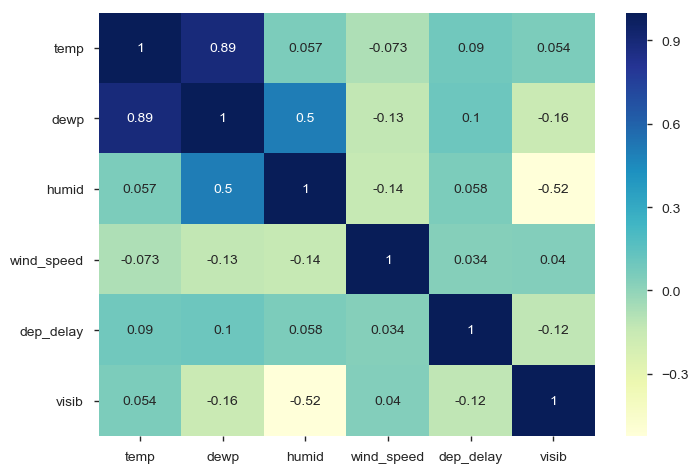

In [23]:
sns.heatmap(weather_airport[['temp','dewp','humid','wind_speed','dep_delay','visib']].corr()
            ,cmap="YlGnBu",annot=True)

Text(0.5,1,'Scatterplot of Dealyed flights')

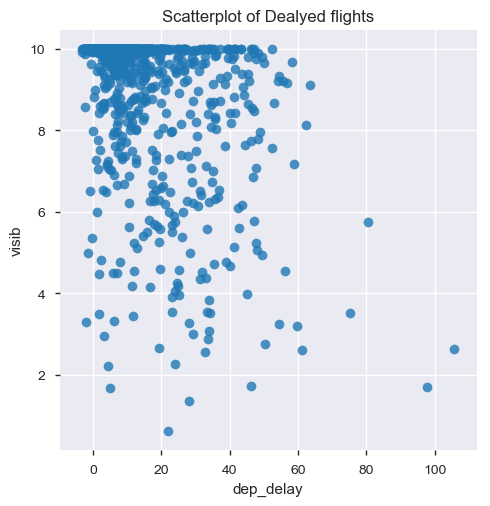

In [24]:
sns.lmplot('dep_delay', 'visib', data=weather_airport_gp, fit_reg=False)
plt.title('Scatterplot of Dealyed flights')

> As seen in heat map and Scatter Plot, better the visibility, less the flight is delayed

Text(0.5,1,'Scatterplot of Dealyed flights')

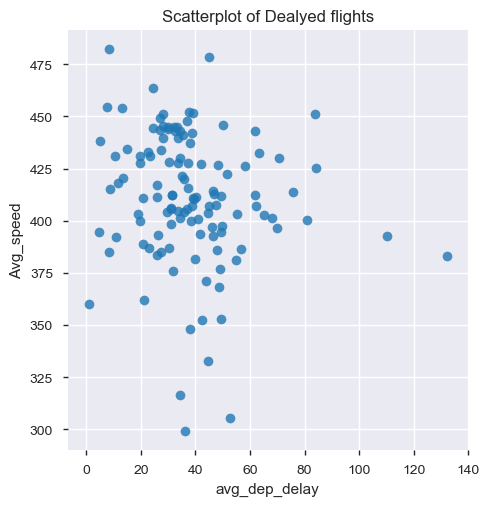

In [27]:
#scatter Plot of delayed flights
airport_data_df['speed(miles/hr)'] = ((airport_data_df['distance'] / airport_data_df['air_time'])* 60).round()

airport_dat = airport_data_df[airport_data_df['dep_delay'] > 0].groupby('model',as_index=False, sort=False) \
.agg({'distance': 'mean', 'speed(miles/hr)':'mean', 'dep_delay':'mean'}) \
.rename (columns={'distance' : 'Average_distance', 'speed(miles/hr)':'Avg_speed', 'dep_delay':'avg_dep_delay' })

sns.lmplot('avg_dep_delay', 'Avg_speed', data=airport_dat, fit_reg=False)
plt.title('Scatterplot of Dealyed flights')

In [28]:
#Getting the list of fastest airplane models
model = airport_dat.sort_values('Avg_speed', ascending=False).head(10)
model['model'].unique()

array(['777-222', 'A330-243', '767-424ER', '737-8FH', '757-212',
       '767-223', 'A319-132', 'A319-115', '757-324', '767-332'],
      dtype=object)

         model  dep_delay_ind  count_of_flights   Avg_speed tailnum  \
60222  767-332              0               690  442.117733  N1200K   
60223  767-332              0               690  442.117733  N1200K   
60224  767-332              0               690  442.117733  N1200K   
60225  767-332              0               690  442.117733  N1200K   
60226  767-332              0               690  442.117733  N1200K   

       year_manu                     type manufacturer  engines  seats  \
60222     1998.0  Fixed wing multi engine       BOEING      2.0  330.0   
60223     1998.0  Fixed wing multi engine       BOEING      2.0  330.0   
60224     1998.0  Fixed wing multi engine       BOEING      2.0  330.0   
60225     1998.0  Fixed wing multi engine       BOEING      2.0  330.0   
60226     1998.0  Fixed wing multi engine       BOEING      2.0  330.0   

            ...         carrier flight  origin  dest  air_time  distance  \
60222       ...              DL    161     JFK   SEA

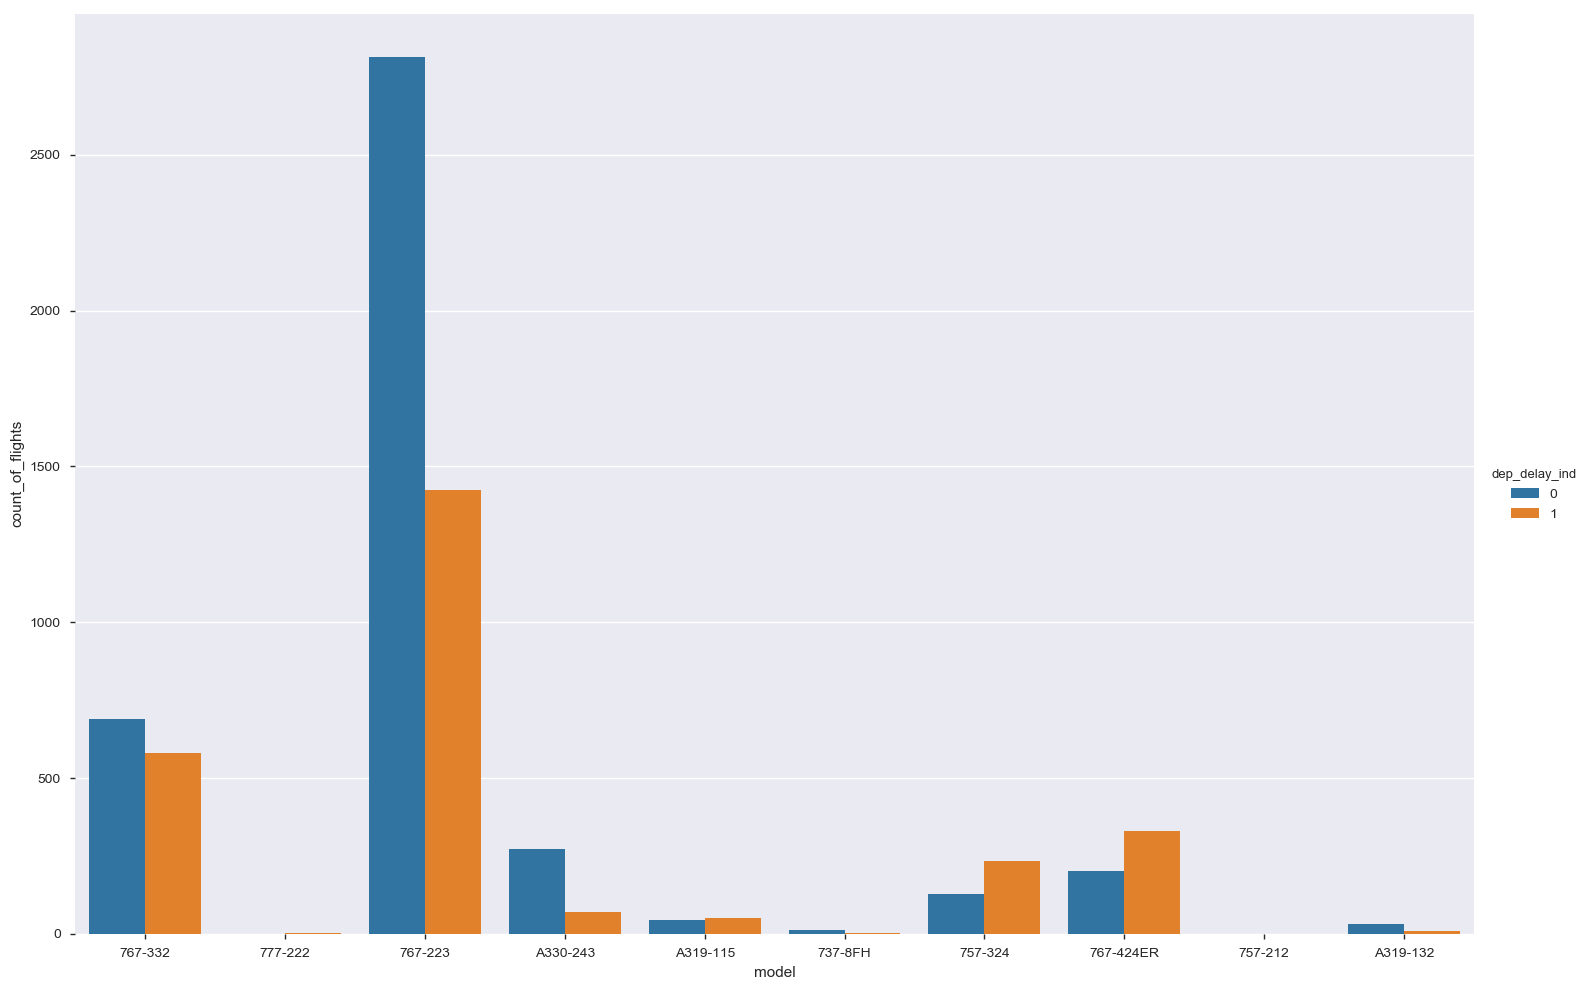

In [29]:
airport_data_model = airport_data_df.groupby(('model','dep_delay_ind'), sort=False)\
.agg({'dep_delay_ind': 'count', 'speed(miles/hr)':'mean'})\
.rename (columns={'dep_delay_ind' : 'count_of_flights', 'speed(miles/hr)':'Avg_speed' }).reset_index()

mod = ['777-222', 'A330-243', '767-424ER', '737-8FH', '757-212',
      '767-223', 'A319-132', 'A319-115', '757-324', '767-332']

airport_data_model_fin = pd.merge(airport_data_model,airport_data_df,how = 'left',left_on=['model','dep_delay_ind'], right_on=['model','dep_delay_ind'])
airport_data_model_fin = airport_data_model_fin[airport_data_model_fin.model.isin(mod)]
print(airport_data_model_fin.head())
ax=sns.catplot(x="model", y="count_of_flights", hue="dep_delay_ind", data=airport_data_model_fin, kind="bar",aspect=1.5, height=10)


#### Flight speed Analysis
> As seen from the above result, flights with high speed tend to have less delays.